In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle

# import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check the sys path to see if the current directory is in the path in colab
import sys
print(sys.path)


['c:\\Users\\Kyriakos\\Desktop\\MsC AI\\NLP\\NLP AirBNB Project\\AirBnB_score_prediction', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\python310.zip', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\DLLs', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1', '', 'C:\\Users\\Kyriakos\\AppData\\Roaming\\Python\\Python310\\site-packages', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\win32', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Kyriakos\\anaconda3\\envs\\nlp1\\lib\\site-packages\\Pythonwin']


In [25]:
df = pd.read_csv('dataset\listings_comments.csv')

In [29]:
pd.set_option('display.max_colwidth', None)
# revoke the display limit of the number of columns
pd.set_option('display.max_columns', None)

In [6]:
label  = df['review_scores_rating'].values

In [7]:
# from embedding.py load the function visualize_3D
from visualization.embedding import *

In [10]:
# from embeddings use the visualize_3D function to visualize the embeddings
visualize_3D(comments_embeddings, label, title="Comments Embeddings", method='tSNE', method_settings={"perplexity":30, "random_state":0})

: 

: 

In [8]:
print(df['comments'].isna().sum())
# fill the nan values in the comments column with 'nan_value'
df['comments'].fillna('nan_value', inplace=True)

682


In [12]:
positive_df = df[df['review_scores_rating'] >= 4.4]
# neutral_df between 4.1 and 4.5
neutral_df = df[(df['review_scores_rating'] >= 4.0) & (df['review_scores_accuracy'] < 4.4)]
# negative_df less than 4.1
negative_df = df[df['review_scores_rating'] < 4.0]

positive_df.shape, neutral_df.shape, negative_df.shape

((6003, 76), (175, 76), (60, 76))

In [13]:

import re
import nltk
from nltk.corpus import stopwords
import string

# define the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# Define regular expression pattern to match stop words
stop_word_regex = r'\b(?:{})\b'.format('|'.join(stop_words))

#  Defining regex for emojis
smileemoji = r"[8:=;]['`\-]?[)d]+"
sademoji = r"[8:=;]['`\-]?\(+"
neutralemoji = r"[8:=;]['`\-]?[\/|l*]"
lolemoji = r"[8:=;]['`\-]?p+"

# pattern for unicode characters
pattern_unicode = r'\\u[0-9A-Fa-f]{4}'

# uncontract the words -eplaces contractions in the text with their corresponding full forms
def uncontract(text):    
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
    
    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    
    return text


# we create a function to pre process the text and we have a default value for normalization. we can change it to stemming or lemmatization
# to check which one is better for our model

def preprocess_text(text, normalization="stemming"):
    # text in the list to lower
    text = [t.lower() for t in text]
    

    # Replace all emojis.
    text = [re.sub(r'<3', '<heart>', t) for t in text]
    text = [re.sub(smileemoji, '<smile>', t) for t in text]
    text = [re.sub(sademoji, '<sadface>', t) for t in text]
    text = [re.sub(neutralemoji, '<neutralface>', t) for t in text]
    text = [re.sub(lolemoji, '<lolface>', t) for t in text]
    
    
    # split and remove the unicode characters
    text = [re.sub(pattern_unicode, '', t) for t in text]

    

    # remove consecutive characters heyyyyy -> heyy
    text = [re.sub(r'(.)\1+', r'\1\1', t) for t in text]

    # Remove punctuation tokens 
    punctuations = set(filter(lambda t: all(c.isdigit() or c in string.punctuation for c in t), text))
    text = [t for t in text if t not in punctuations]


#     # Remove stopwords 
    text = [re.sub(stop_word_regex, '', t) for t in text]



    #removing shortwords smaller that 3 characters
    clean_tokens = [w for w in text if len(w)>=3]


#     Apply stemming  or lemmatization 
    
    if normalization == "stemming":
        for i, t in enumerate(clean_tokens):        
            t = ps.stem(t)
            clean_tokens[i] = t

    else:
        print("lemmatization")
        for i, t in enumerate(clean_tokens):
            t = lemmatizer.lemmatize(t)
            clean_tokens[i] = t

    return [t for t in clean_tokens if len(t) > 0]





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# uncontract("I'm not going to do itiii, heyyyyyyyyy")
# preprocess_text("I'm not going to do itiii, heyyyyyyyyy")

In [15]:
positive_comments = [str(comment) for comment in positive_df['comments'] if isinstance(comment, str)]
positive_comments = ''.join(positive_comments).split()

neutral_comments = [str(comment) for comment in neutral_df['comments'] if isinstance(comment, str)]
neutral_comments = ''.join(neutral_comments).split()

negative_comments = [str(comment) for comment in negative_df['comments'] if isinstance(comment, str)]
negative_comments = ''.join(negative_comments).split()

In [16]:
# preprocess the comments with stemming

positive_comments = preprocess_text(positive_comments, "lemmatization")
neutral_comments = preprocess_text(neutral_comments, "lemmatization")
negative_comments = preprocess_text(negative_comments, "lemmatization")

lemmatization
lemmatization
lemmatization


In [17]:
# remove neutral and popular words like "amstermdam", "location", "apartment", "br", "place"  comments
remove_words = ["amsterdam", "location", "apartment", "br", "place", "house", "room", "flat", "home", "host"]
positive_comments = [word for word in positive_comments if word not in remove_words]
negative_comments = [word for word in negative_comments if word not in remove_words]
neutral_comments = [word for word in neutral_comments if word not in remove_words]


In [21]:
positive_comments[:10]

["['daniel",
 'really',
 'cool.',
 'nice',
 'clean.',
 'quiet',
 'neighborhood.',
 'map',
 'lonely',
 'planet']

In [22]:
# apply the wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# positive comments
positive_wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(' '.join(positive_comments))
neutral_wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(' '.join(neutral_comments))
negative_wordcloud = WordCloud(width=800, height=500, max_font_size=110, collocations=False).generate(' '.join(negative_comments))


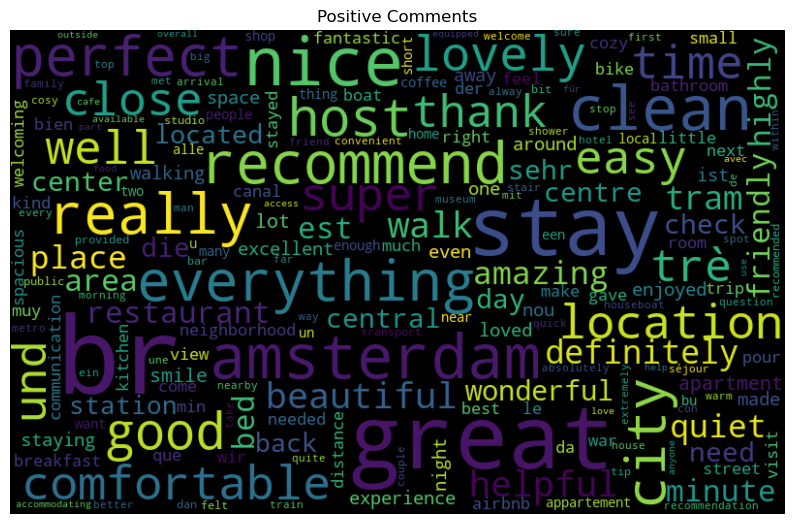

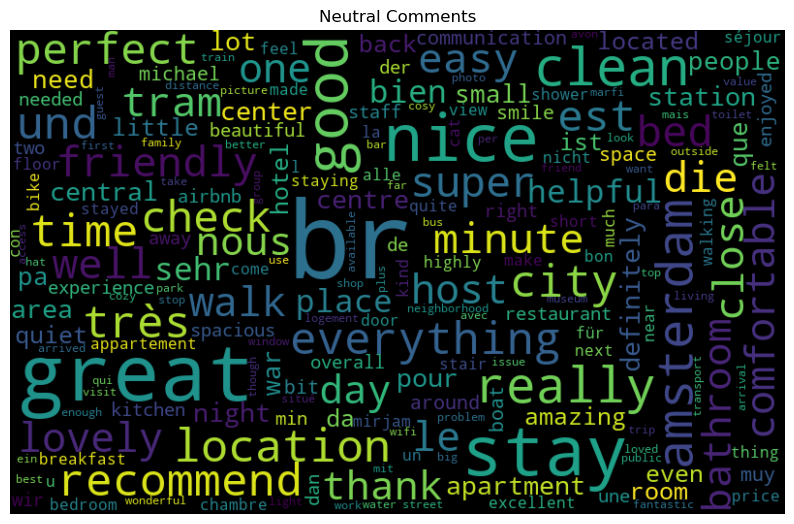

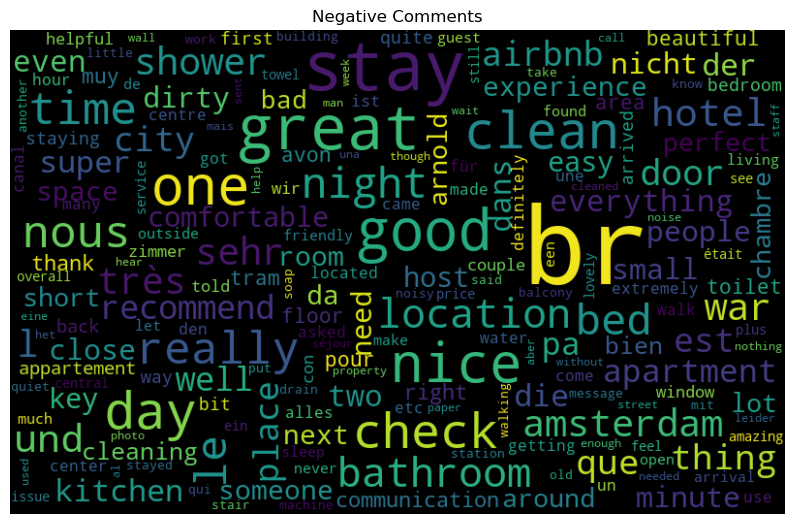

In [23]:
def plot_wordcloud(wordcloud, title):
    plt.figure(figsize=(10, 7))
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

plot_wordcloud(positive_wordcloud, "Positive Comments")
plot_wordcloud(neutral_wordcloud, "Neutral Comments")
plot_wordcloud(negative_wordcloud, "Negative Comments")